In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from pandas.plotting import scatter_matrix
import scipy.stats as st
from scipy.stats import norm

%matplotlib inline

plt.style.use('bmh')

### Data set fields
* `vendor_id` - a code indicating the provider associated with the trip record - **FEATURE**
* `pickup_datetime` - date and time when the meter was engaged - **FEATURE**
* `dropoff_datetime` - date and time when the meter was disengaged - **TARGET**
* `passenger_count` - the number of passengers in the vehicle (driver entered value) - **FEATURE**
* `pickup_longitude` - the longitude where the meter was engaged - **FEATURE**
* `pickup_latitude` - the latitude where the meter was engaged - **FEATURE**
* `dropoff_longitude` - the longitude where the meter was disengaged - **FEATURE**
* `dropoff_latitude` - the latitude where the meter was disengaged - **FEATURE**
* `store_and_fwd_flag` - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip - **FEATURE**
* `trip_duration` - duration of the trip in seconds - **TARGET**

## 1. Load and Preprocessing Data

In [120]:
data = pd.read_csv('nyc-taxi-trip-duration-from_kaggle/train.csv')
#test = pd.read_csv('nyc-taxi-trip-duration-from_kaggle/test.csv',index_col='id')
#sample_submission = pd.read_csv('nyc-taxi-trip-duration-from_kaggle/sample_submission.csv',index_col='id')

In [121]:
print('The data set set has {:,} observations. \n'.format(len(data)))
print(data.dtypes)
print(data.head())

The data set set has 1,458,644 observations. 

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object
          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415      

### 1.1 Verifying missing values
It's important to verify if there are any observations missing values. There are none.

In [41]:
data.isnull().values.any()

False

### 1.2 Dropping of unecessary information

As `dropoff_datetime`-`pickup_datetime` = `trip_duration`, the feature `dropoff_datetime` can be dropped.

In [122]:
data = data.drop(columns='dropoff_datetime')

### 1.3 Dealing with categorical variables

The features `store_and_fwd_flag`, `vendor_id` and `passenger_count` are *categorical* variables.

### 1.4 Converting pickup datetime to time stamp

Conveniently convert the field `pickup_datetime` to a *timestamp* object.

In [123]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')

### 1.5 Converting trip duration to continuous

And the `trip_duration` should be converted to *float* in order to "make" it *continuous*.

In [124]:
data['trip_duration'] = data['trip_duration'].astype('float')

In [125]:
data.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                float64
dtype: object

The remaining features are already *continuous*.

### 1.6 Calculating the distance between two coordinates

One should convert the two coordinates for latitude and longitude to distance. For this, it will be used **proj.Geod**.

https://proj.org/geodesic.html - Documentation


http://www.meridianoutpost.com/resources/etools/calculators/calculator-latitude-longitude-distance.php?
From: (40°46'4.5731999999998"N -73°58'55.758"E) To: (40°45'56.1672"N -73°57'52.668"E)
0.93 miles / 1.50 kilometers / 0.81 nautical miles
From: (40°44'18.8304"N -73°58'49.494"E) To: (40°43'52.1472"N -73°59'58.1316"E)
1.12 miles / 1.81 kilometers / 0.97 nautical miles
From: (40°47'52.0044"N -73°58'9.3935999999999"E) To: (40°45'38.0124"N -73°55'20.892"E)
3.55 miles / 5.71 kilometers / 3.08 nautical miles
From: (40°46'37.6824"N -73°57'18.8316"E) To: (40°38'29.2992"N -73°47'19.5"E)
12.80 miles / 20.60 kilometers / 11.12 nautical miles

In [126]:
from pyproj import Geod

wgs84_geod = Geod(ellps='WGS84') #Distance will be measured on this ellipsoid - more accurate than a spherical method

def Distance(lat1,lon1,lat2,lon2):
  _,_,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2) #Yes, this order is correct
  return dist

data['dist'] = Distance(data['pickup_latitude'].tolist(),
                        data['pickup_longitude'].tolist(),
                        data['dropoff_latitude'].tolist(),
                        data['dropoff_longitude'].tolist())

#data = data.drop(columns=['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'])

**Dealing with zero distance.**

Since gps accuracy goes 4digits that is the taxi didn't move more then 40.000/360=111km per degrees / 10.000 = > 11meter ?

* Person gets in cab during heavy traffic when after a few minutes the cab hasn't moved the person wants to get out and walk/take the subway/try a cab a few blocks over that mightn't be stuck in gridlock
* Cab parked at lot after shifts/for maintenance but the meter is left running by mistake
*  GPS might be not be accurate due to large buildings blocking/interfering with the signal and hence the data might be the last position the device was able to read

They will be dismissed.

In [127]:
#print((data['pickup_latitude'][data['dist']==0] == data['dropoff_latitude'][data['dist']==0]).all())
#print((data['pickup_longitude'][data['dist']==0] == data['dropoff_longitude'][data['dist']==0]).all())
#plt.figure(1)
#sb.distplot(data['trip_duration'][(data['dist']==0)&(data['trip_duration']<200)])

#plt.figure(2)
#sb.distplot(data['trip_duration'][(data['dist']==0)&(data['trip_duration']<10000)&(data['trip_duration']>200)])

#plt.figure(3)
#sb.distplot(data['trip_duration'][(data['dist']==0)&(data['trip_duration']>10000)])
data = data[data['dist']>0].copy()

In [128]:
data.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                float64
dist                         float64
dtype: object

## 2. Data exploring and transformation

### 2.1 Distance and trip duration

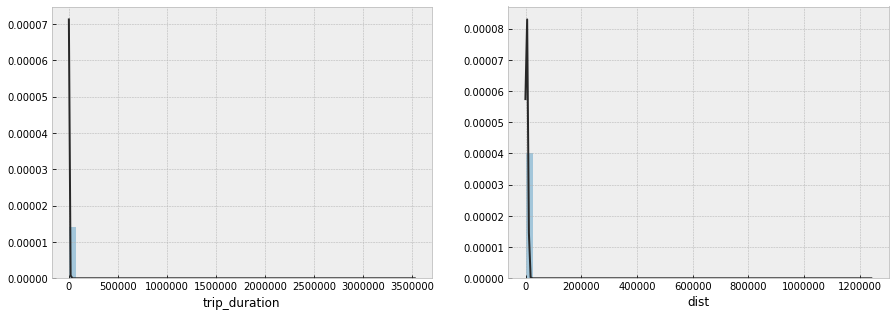

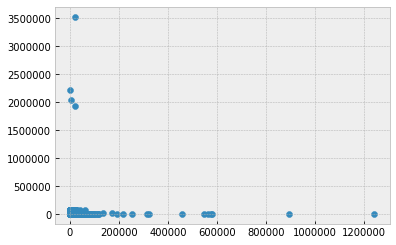

In [51]:
fig = plt.figure(1,figsize=(15,5))

ax1 = fig.add_subplot(121)
sb.distplot(data['trip_duration'],kde=False,fit=norm)

ax2 = fig.add_subplot(122)
sb.distplot(data['dist'],kde=False,fit=norm)

plt.figure(2)
plt.scatter(data['dist'],data['trip_duration'])

#### 2.1.1 Choosing the transformation 

Box-Cox vs. Logarithmic

In [130]:
data['log_trip_duration'] = np.log(data['trip_duration'])
data['bc_trip_duration'], _ = st.boxcox(data['trip_duration'])
data['log_dist'] = np.log(data['dist'])
data['bc_dist'], _ = st.boxcox(data['dist'])

NameError: name 'st' is not defined

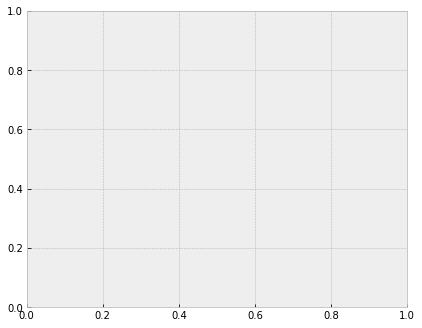

In [50]:
def prob_plot(data):    
    fig = plt.figure(1,figsize=(15,12))

    ax1 = fig.add_subplot(221)
    prob = st.probplot(data['log_trip_duration'], dist=st.norm, plot=ax1)
    ax1.set_title('Prob Plot - log_trip_duration')

    ax2 = fig.add_subplot(222)
    prob = st.probplot(data['bc_trip_duration'], dist=st.norm, plot=ax2)
    ax2.set_title('Prob Plot - bc_trip_duration')

    ax3 = fig.add_subplot(223)
    prob = st.probplot(data['log_dist'], dist=st.norm, plot=ax3)
    ax3.set_title('Prob Plot - log_dist')

    ax4 = fig.add_subplot(224)
    prob = st.probplot(data['bc_dist'], dist=st.norm, plot=ax4)
    ax4.set_title('Prob Plot - bc_dist')

    fig.show()

prob_plot(data)

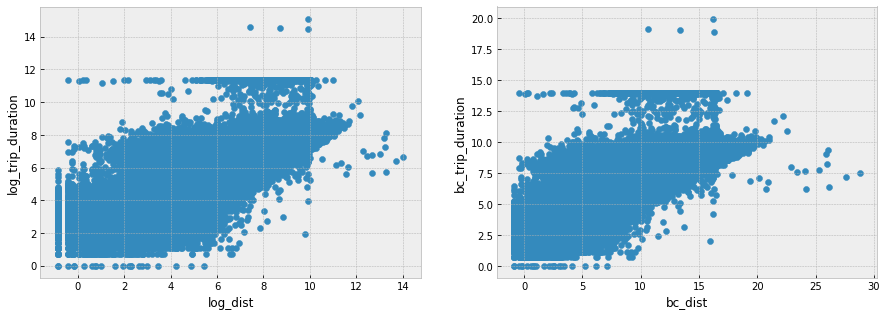

In [38]:
def scatter_combo(data):
    fig = plt.figure(figsize=(15,5))

    ax1 = fig.add_subplot(121)
    ax1.scatter(data['log_dist'].values,data['log_trip_duration'].values)
    ax1.set_xlabel('log_dist')
    ax1.set_ylabel('log_trip_duration')

    ax2 = fig.add_subplot(122)
    ax2.scatter(data['bc_dist'].values,data['bc_trip_duration'].values)
    ax2.set_xlabel('bc_dist')
    ax2.set_ylabel('bc_trip_duration')

scatter_combo(data)

C:\Users\Cora\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


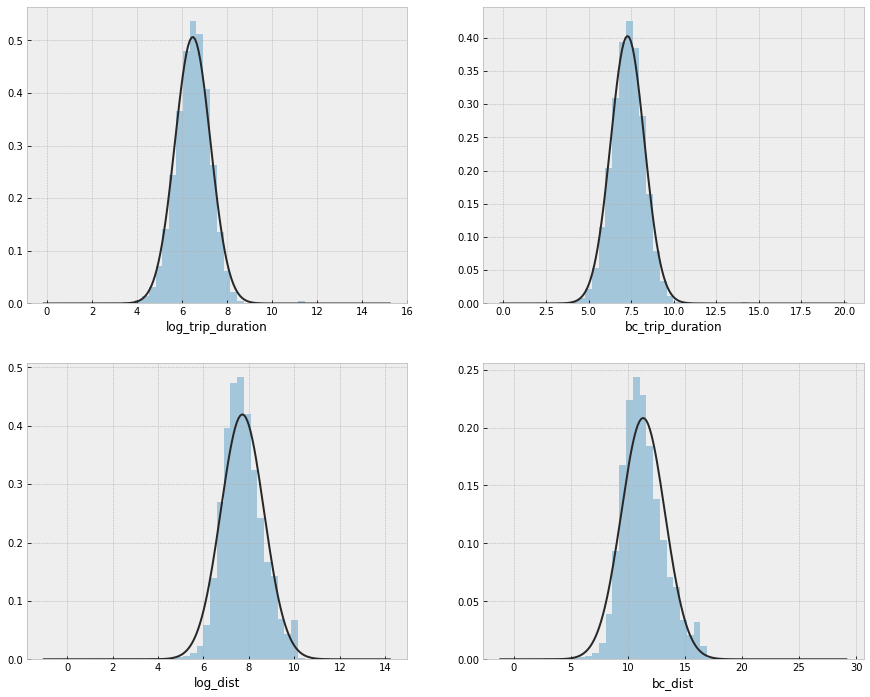

In [39]:
def dist_combo(data):    
    fig = plt.figure(figsize=(15,12))

    ax1 = fig.add_subplot(221)
    sb.distplot(data['log_trip_duration'],kde=False,fit=norm)

    ax2 = fig.add_subplot(222)
    sb.distplot(data['bc_trip_duration'],kde=False,fit=norm)

    ax3 = fig.add_subplot(223)
    sb.distplot(data['log_dist'],kde=False,fit=norm)

    ax4 = fig.add_subplot(224)
    sb.distplot(data['bc_dist'],kde=False,fit=norm)

    fig.show()

dist_combo(data)

It is not good to decide which transformation to perform. Perhaps, it is a good idea to treat the outliers first.

#### 2.1.1 Treating outliers 

C:\Users\Cora\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


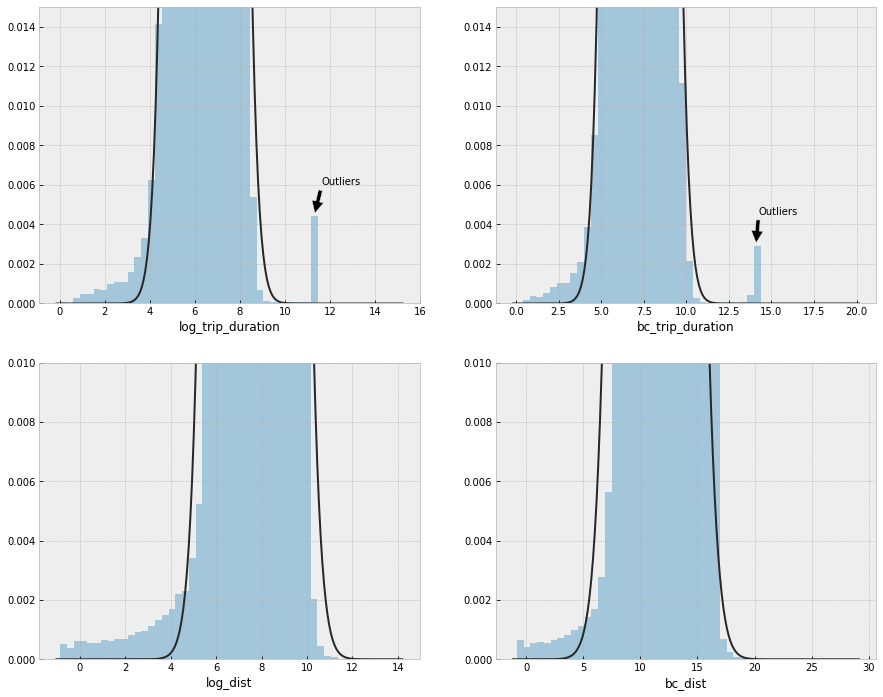

In [40]:
fig = plt.figure(figsize=(15,12))

ax1 = fig.add_subplot(221)
data['log_trip_duration'] = np.log(data['trip_duration'])
sb.distplot(data['log_trip_duration'],kde=False,fit=norm)
ax1.set_ylim([0,0.015])
ax1.annotate('Outliers',
             xy=(data['log_trip_duration'][data['log_trip_duration']>10].mean(),0.0045),
             xytext=(data['log_trip_duration'][data['log_trip_duration']>10].mean()+0.3,0.006),
             arrowprops=dict(facecolor='black', shrink=0.05))

ax2 = fig.add_subplot(222)
data['bc_trip_duration'], _ = st.boxcox(data['trip_duration'])
sb.distplot(data['bc_trip_duration'],kde=False,fit=norm)
ax2.set_ylim([0,0.015])
ax2.annotate('Outliers',
             xy=(data['bc_trip_duration'][data['log_trip_duration']>10].mean()+0.15,0.0030),
             xytext=(data['bc_trip_duration'][data['log_trip_duration']>10].mean()+0.3,0.0045),
             arrowprops=dict(facecolor='black', shrink=0.05))

ax3 = fig.add_subplot(223)
data['log_dist'] = np.log(data['dist'])
sb.distplot(data['log_dist'],kde=False,fit=norm)
ax3.set_ylim([0,0.01])

ax4 = fig.add_subplot(224)
data['bc_dist'], _ = st.boxcox(data['dist'])
sb.distplot(data['bc_dist'],kde=False,fit=norm)
ax4.set_ylim([0,0.01])

fig.show()

In [131]:
print('The outliers average duration trip is of {:2.1f} hours.'.format(np.exp(data['log_trip_duration'][data['log_trip_duration']>10].mean())/3600.))

The outliers average duration trip is of 22.8 hours.


Is is most probable that these trips are actually the time in which the taxi didn't work. They will be discarded.

In [132]:
#Stores the index of the first set of outliers
idx_1 = data[data['log_trip_duration']>10].index

#Creates a new data frame whith the outliers
data1 = data[data['log_trip_duration']<=10].copy()

**Velocity limit**

One should not expect that

After removing the first batch of outliers, the Box-Cox transformation is performed once again because the optimal power may change.

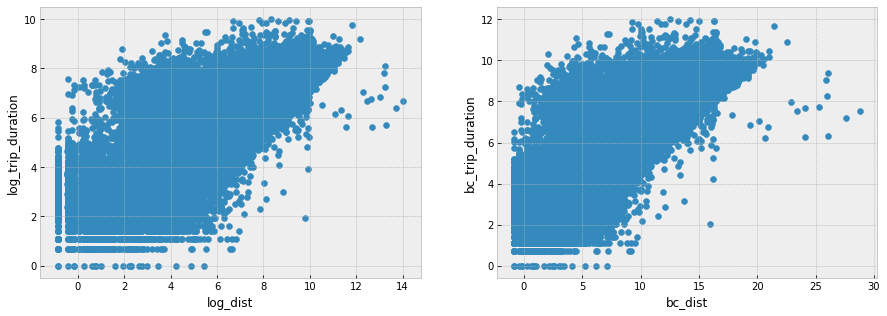

In [43]:
scatter_combo(data1)

One should expect that there's a speed limit to the taxis. 

In [133]:
data1['vel'] = data1['dist']/data['trip_duration']*3.6

Text(0, 0.5, 'bc_trip_duration')

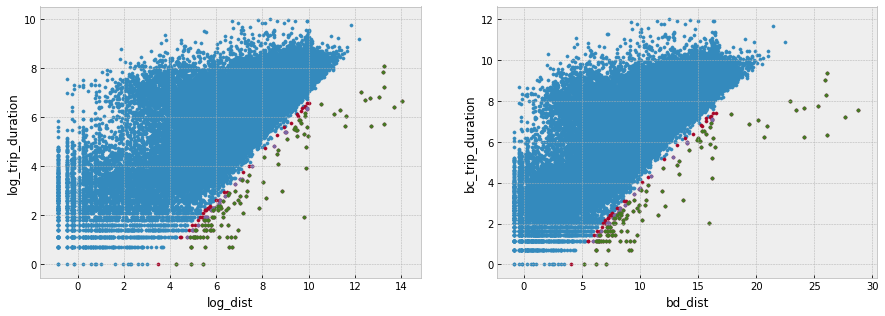

In [44]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
ax1.scatter(data1['log_dist'][data1['vel']<100],data1['log_trip_duration'][data1['vel']<100],s=10)
ax1.scatter(data1['log_dist'][data1['vel']>100],data1['log_trip_duration'][data1['vel']>100],s=10)
ax1.scatter(data1['log_dist'][data1['vel']>120],data1['log_trip_duration'][data1['vel']>120],s=10)
ax1.scatter(data1['log_dist'][data1['vel']>140],data1['log_trip_duration'][data1['vel']>140],s=10)
ax1.set_xlabel('log_dist')
ax1.set_ylabel('log_trip_duration')

ax2 = fig.add_subplot(122)
ax2.scatter(data1['bc_dist'][data1['vel']<100],data1['bc_trip_duration'][data1['vel']<100],s=10)
ax2.scatter(data1['bc_dist'][data1['vel']>100],data1['bc_trip_duration'][data1['vel']>100],s=10)
ax2.scatter(data1['bc_dist'][data1['vel']>120],data1['bc_trip_duration'][data1['vel']>120],s=10)
ax2.scatter(data1['bc_dist'][data1['vel']>140],data1['bc_trip_duration'][data1['vel']>140],s=10)
ax2.set_xlabel('bd_dist')
ax2.set_ylabel('bc_trip_duration')

It will be used 140km/h.

In [134]:
idx_2 = data1[data1['vel']>140].index

data2 = data1[data1['vel']<=140].copy()

#scatter_combo(data2)

#### 2.2 Weekday, holiday, special day events and hour influences

In [188]:
from datetime import date
import holidays

ny_holidays = holidays.UnitedStates(state='NY')
ny_holidays = ny_holidays[data2['pickup_datetime'].dt.date.min(): data2['pickup_datetime'].dt.date.max()]

data2['week_day'] = data2['pickup_datetime'].dt.weekday_name

#New York Holiday
data2['holiday'] = 0
data2['holiday'] = np.where(data2['pickup_datetime'].dt.date.isin(ny_holidays),
                            1,
                            0)
#Special Events
## New Year's Day 1/1/2016
## St. Patrick's Day 17/3/2016
## Valentine's Day 12/2/2016
data2['special'] = 0
data2['special'] = np.where(data2['pickup_datetime'].dt.date.isin([date(2016,1,1),date(2016,3,17),date(2016,2,12)]),
                            1,
                            0)

Text(0.5, 1.0, 'Special=0; Holiday=0')

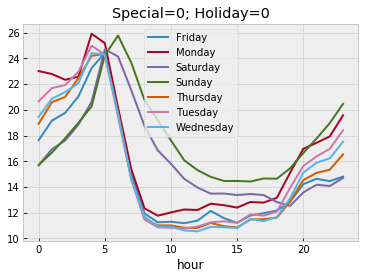

In [136]:
data2['hour'] = data2['pickup_datetime'].dt.hour
days = data2[['vel','trip_duration','hour','week_day','holiday','special']].groupby(['hour','week_day','holiday','special']).agg('mean').reset_index(drop=False)

plt.figure(1)
for wd in days['week_day'][(days['holiday']==0)&(days['special']==0)].unique():
    plt.plot(days['hour'][(days['week_day']==wd)&(days['holiday']==0)&(days['special']==0)],
             days['vel'][(days['week_day']==wd)&(days['holiday']==0)&(days['special']==0)],
             label=wd)
plt.legend()
plt.xlabel('hour')
plt.title('Special=0; Holiday=0')

Text(0.5, 1.0, 'Special=1; Holiday=1')

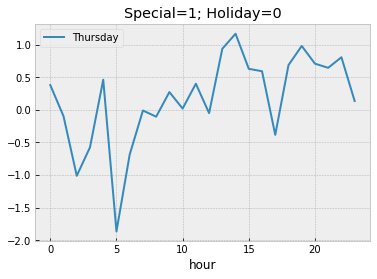

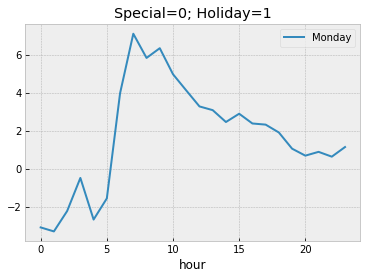

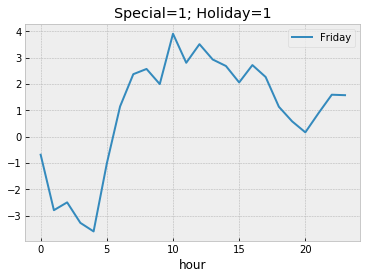

In [137]:
non_special = pd.merge(days[~((days['special']==0)&(days['holiday']==0))],
                       days[['week_day','hour','vel']][((days['special']==0)&(days['holiday']==0))],
                       right_on=['week_day','hour'],
                       left_on=['week_day','hour'],
                       how='left')
non_special['vel_dif'] = non_special['vel_x'] - non_special['vel_y']

s = 1
h = 0
plt.figure(1)
for wd in non_special['week_day'][(non_special['holiday']==h)&(non_special['special']==s)].unique():
    plt.plot(non_special['hour'][(non_special['week_day']==wd)&(non_special['holiday']==h)&(non_special['special']==s)],
             non_special['vel_dif'][(non_special['week_day']==wd)&(non_special['holiday']==h)&(non_special['special']==s)],
             label=wd)
plt.legend()
plt.xlabel('hour')
plt.title('Special='+str(s)+'; Holiday='+str(h))

s = 0
h = 1
plt.figure(2)
for wd in non_special['week_day'][(non_special['holiday']==h)&(non_special['special']==s)].unique():
    plt.plot(non_special['hour'][(non_special['week_day']==wd)&(non_special['holiday']==h)&(non_special['special']==s)],
             non_special['vel_dif'][(non_special['week_day']==wd)&(non_special['holiday']==h)&(non_special['special']==s)],
             label=wd)
plt.legend()
plt.xlabel('hour')
plt.title('Special='+str(s)+'; Holiday='+str(h))

s = 1
h = 1
plt.figure(3)
for wd in non_special['week_day'][(non_special['holiday']==h)&(non_special['special']==s)].unique():
    plt.plot(non_special['hour'][(non_special['week_day']==wd)&(non_special['holiday']==h)&(non_special['special']==s)],
             non_special['vel_dif'][(non_special['week_day']==wd)&(non_special['holiday']==h)&(non_special['special']==s)],
             label=wd)
plt.legend()
plt.xlabel('hour')
plt.title('Special='+str(s)+'; Holiday='+str(h))

#### 2.3 Week of the year influence

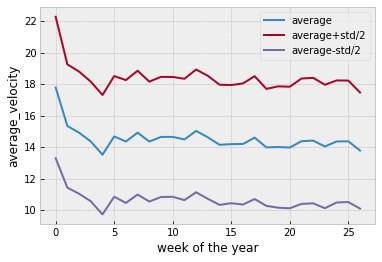

In [193]:
data2['week'] = np.where(data2['pickup_datetime'].dt.week==53,0,data2['pickup_datetime'].dt.week)

avg = data2[['vel','trip_duration','week']].groupby(['week']).agg('mean').reset_index(drop=False)
std = data2[['vel','trip_duration','week']].groupby(['week']).agg('std').reset_index(drop=False)

plt.figure(1)
plt.plot(avg['week'],avg['vel'],label='average')
plt.plot(avg['week'],avg['vel']+std['vel']/2,label='average+std/2')
plt.plot(avg['week'],avg['vel']-std['vel']/2,label='average-std/2')

plt.legend()
plt.xlabel('week of the year')
plt.ylabel('average_velocity')

del data2['week']

#### 2.4 Day of the month influence

Text(0, 0.5, 'average_velocity')

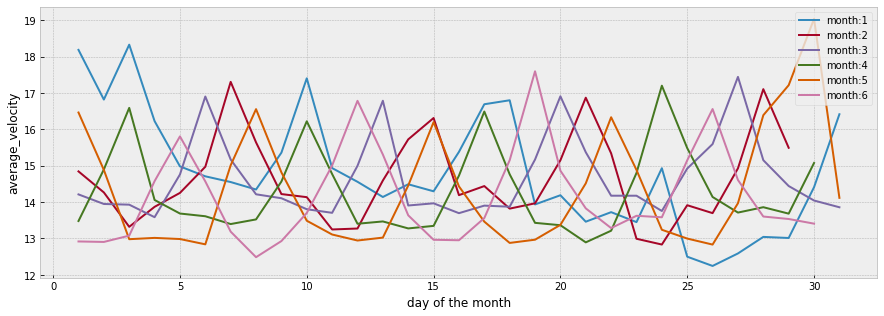

In [139]:
data2['day'] = data2['pickup_datetime'].dt.day
data2['month'] = data2['pickup_datetime'].dt.month

avg = data2[['vel','trip_duration','day','month']].groupby(['day','month']).agg('mean').reset_index(drop=False)

plt.figure(figsize=(15,5))
for month in avg['month'].unique():
    plt.plot(avg['day'][avg['month']==month],avg['vel'][avg['month']==month],label='month:' + str(month))

plt.legend()
plt.xlabel('day of the month')
plt.ylabel('average_velocity')

#### 2.4 Vendor influence

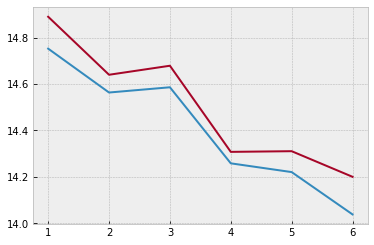

In [181]:
def plot_feature(data2,featurex,featurey,featurez):
    avg = data2[[featurey,featurex,featurez]].groupby([featurex,featurez]).agg('mean').reset_index(drop=False)

    plt.plot(avg[featurex][avg[featurez]==avg[featurez].unique()[0]],avg[featurey][avg[featurez]==avg[featurez].unique()[0]],label='average')
    plt.plot(avg[featurex][avg[featurez]==avg[featurez].unique()[1]],avg[featurey][avg[featurez]==avg[featurez].unique()[1]],label='average')

plot_feature(data2,'month','vel','vendor_id')

#### 2.5 Passenger count

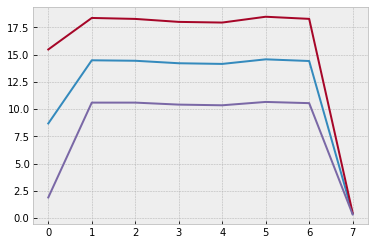

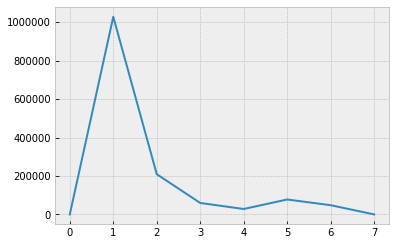

In [187]:
avg = data2[['vel','passenger_count']].groupby(['passenger_count']).agg('mean').reset_index(drop=False)
std = data2[['vel','passenger_count']].groupby(['passenger_count']).agg('std').reset_index(drop=False)

plt.figure(1)
plt.plot(avg['passenger_count'],avg['vel'],label='average')
plt.plot(avg['passenger_count'],avg['vel']+std['vel']/2,label='average')
plt.plot(avg['passenger_count'],avg['vel']-std['vel']/2,label='average')

data2['count'] = 1
count = data2[['count','passenger_count']].groupby(['passenger_count']).agg('sum').reset_index(drop=False)

plt.figure(2)
plt.plot(count['passenger_count'],count['count'])

del data2['count']

In [168]:
print('There are {} observations with 0 passengers'.format(len(data2[data2['passenger_count']==0])))
print('There are {} observations with 7 passengers'.format(len(data2[data2['passenger_count']==7])))

There are 50 observations with 0 passengers
There are 2 observations with 7 passengers


As they are not big samples, the reason the average velocity is diferent is because the sample are biased. The observations with other number of passanger do not depend on the number of passengers. That's why this feature will be disconsiderd. This is reasanable because one shouldn't expect that the drip duration would depend on passenger counting.

In [194]:
data3 = data2.drop(columns='passenger_count')

#### 2.6 store_and_fwd_flag

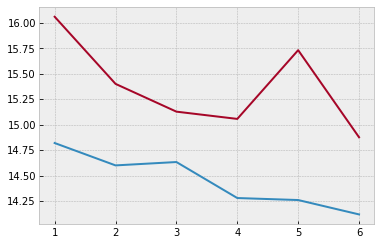

In [191]:
plot_feature(data3,'month','vel','store_and_fwd_flag')

In [195]:
data3.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                float64
dist                         float64
log_trip_duration            float64
bc_trip_duration             float64
log_dist                     float64
bc_dist                      float64
vel                          float64
week_day                      object
holiday                        int32
special                        int32
hour                           int64
day                            int64
month                          int64
dtype: object

In [142]:
print('vendor_id: ',data['vendor_id'].unique())
print('store_and_fwd_flag: ',data['store_and_fwd_flag'].unique())
print('passenger_count: ',data['passenger_count'].unique())

vendor_id:  [2 1]
store_and_fwd_flag:  ['N' 'Y']
passenger_count:  [1 6 4 2 3 5 0 7 8]


And will be treated by *dummy variables*.

In [7]:
data = pd.get_dummies(data,columns=['store_and_fwd_flag','vendor_id','passenger_count'])

In [178]:
data3['week_day'].unique()

array(['Monday', 'Sunday', 'Tuesday', 'Wednesday', 'Saturday', 'Friday',
       'Thursday'], dtype=object)